# Objective: derive $\Delta$s from Monsoon Output




## Study area
As a reminder here is again the domains of our LES setup:

In [2]:
# make the notebook more readable:
import warnings
warnings.filterwarnings('ignore')

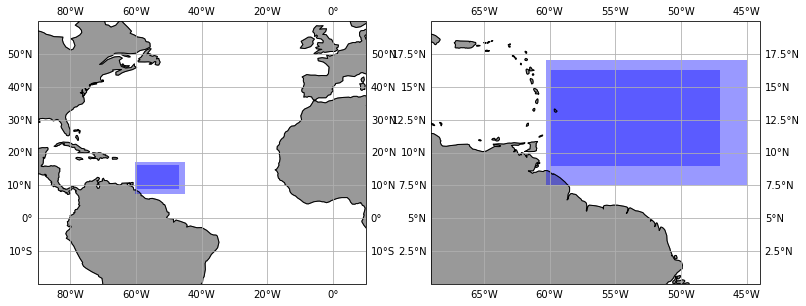

In [3]:
import prelim
map_extents = [(-90,+10,-20,+60), 
               (-69,-44, +0,+20)]

fig, axs = prelim.plot_grid_rectangles(map_extents)

## Monsoon dataset
The *Monsoon 2.0* dataset ([M2](https://gist.github.com/lkluft/d97a5edef6f1b42bc648a9089a7e03d7)) consists of several runs. It includes a the RCP4.5 and RCP8.5 scenarios and a control mini ensemble with 4 members each. While the control scenarios are forced with ERA5, the RCP scenarios are based on ICON runs. M2 is atmosphere only and thus the SST should mirror the forcings. The RCP (Representative Concentration Pathway) are scenarios of greenhouse gas concentration, coined by the IPCC, labelled after a possible range of radiative forcing values in the year 2100 (4.5 and 8.5 W/m2, respectively). Monsoon uses the 2070 state of the scenarios (50 years into the future) when the RCP4.5 is at around 500 and the RCP8.5 at around 800 ppm CO2.

<p style="text-align:center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/a/ab/All_forcing_agents_CO2_equivalent_concentration.svg" alt="drawing" width="500"/>
</p>

It should be possible to compute deltas (differences) from the these. As there is only 2D data available, I decided to first just go for SST (labeled `ts` in the M2; should mirror the forcings as described above).

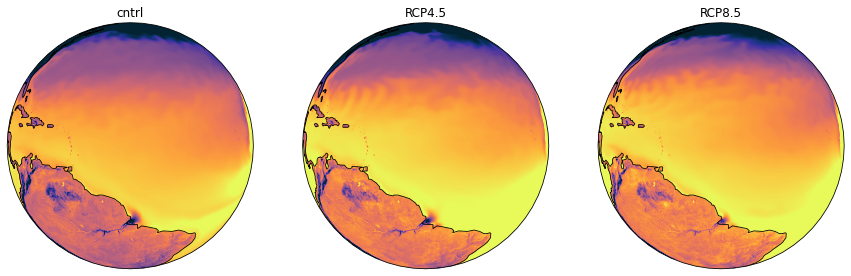

In [4]:
varname = 'ts'
time = 4000
time = 500
data = [prelim.monsoon_dataset('luk1000'), prelim.monsoon_dataset('luk1010'), prelim.monsoon_dataset('luk1020')]
labels = ['cntrl', 'RCP4.5', 'RCP8.5']
grid = prelim.matching_grid(data[0])
viewpoint=(-50, 15, 2e6)
vminmax = (10 + 273, 30 + 273) # degree Kelvin

prelim.plot_dual_globe(data, grid, varname, timeindex=time, viewpoint=viewpoint, vminmax=vminmax, labels=labels)

And having a closer look at our Eurec4a domain, with a consistant colorscale:

In [5]:
domain_limits = prelim.latlon_limits(prelim.eureca_grid())
prelim.plot_monsoon_warming_comparison_domain(domain_limits)

## Derive deltas
Now it should only be a matter of substracting the two. But that does not work. I receive a `DataArray` without extent in the `time` dimension.

In [5]:
varname='ts'
ctrl = prelim.cut_latlon_box(prelim.monsoon_dataset('luk1000', grid=True), domain_limits)[varname]
pl4k = prelim.cut_latlon_box(prelim.monsoon_dataset('luk1010', grid=True), domain_limits)[varname]

delta = ctrl - pl4k
for d in delta.dims:
    print(f"shape of {d}: {delta[d].shape}")

shape of time: (0,)
shape of cell: (71589,)


This [points to mismatch in the time dimension](https://stackoverflow.com/q/52869951). The time array should be identical for `xarray` to compute the `a - b` operation without problems. So lets look at them again:

In [6]:
print(f"index: {'time in ctrl,'.ljust(30)} {'time in pl4k,'.ljust(30)} are they equal?")
for i in range(5):
    print(f"{str(i).rjust(5)}: {ctrl.time.values[i]}, {pl4k.time.values[i]}, {ctrl.time.values[i] == pl4k.time.values[i]}")

index: time in ctrl,                  time in pl4k,                  are they equal?
    0: 2020-04-01T00:00:00.000000000, 2070-04-01T00:00:00.000000000, False
    1: 2020-04-01T00:30:00.000000000, 2070-04-01T00:30:00.000000000, False
    2: 2020-04-01T01:00:00.000000000, 2070-04-01T01:00:00.000000000, False
    3: 2020-04-01T01:30:00.000000000, 2070-04-01T01:30:00.000000000, False
    4: 2020-04-01T02:00:00.000000000, 2070-04-01T02:00:00.000000000, False


The global warming scenario is set in the year 2070. We would have to add substract 50 from its timestamps to bring it to match with the control run.

In [7]:
import numpy as np

fifty_years = np.datetime64('2070-01-01') - np.datetime64('2020-01-01') 
fifty_years = fifty_years - np.timedelta64(1,'D')
pl4k['time'] = pl4k.time.values - fifty_years

print(f"index: {'time in ctrl,'.ljust(30)} {'time in pl4k,'.ljust(30)} are they equal?")
for i in range(5):
    print(f"{str(i).rjust(5)}: {ctrl.time.values[i]}, {pl4k.time.values[i]}, {ctrl.time.values[i] == pl4k.time.values[i]}")

index: time in ctrl,                  time in pl4k,                  are they equal?
    0: 2020-04-01T00:00:00.000000000, 2020-04-01T00:00:00.000000000, True
    1: 2020-04-01T00:30:00.000000000, 2020-04-01T00:30:00.000000000, True
    2: 2020-04-01T01:00:00.000000000, 2020-04-01T01:00:00.000000000, True
    3: 2020-04-01T01:30:00.000000000, 2020-04-01T01:30:00.000000000, True
    4: 2020-04-01T02:00:00.000000000, 2020-04-01T02:00:00.000000000, True


Do the times match now? Sadly no. But whos fault is it?

In [8]:
print(f"Are time arrays equal?: {np.isin(ctrl.time, pl4k.time).all()}")
print(f"Does the lengths match?: {ctrl.time.shape == pl4k.time.shape}")
print(f"What are the lengths?: {len(ctrl.time), len(pl4k.time)}")
blame = ctrl.time.values[np.isin(ctrl.time, pl4k.time, invert=True)][0]
print(f"What is the extra time step in `ctrl`?: {blame}")

Are time arrays equal?: False
Does the lengths match?: False
What are the lengths?: (8785, 8784)
What is the extra time step in `ctrl`?: 2020-09-01T00:00:00.000000000


That probably means it has nothing to do with 2020 being a leap year. We will just drop this entry for now.

In [9]:
ctrl = ctrl.where(ctrl.time != blame, drop=True)
print(f"Are time arrays equal?: {np.isin(ctrl.time, pl4k.time).all()}")

Are time arrays equal?: True


Now it should work. And it does. Here is how a timeslice looks like:

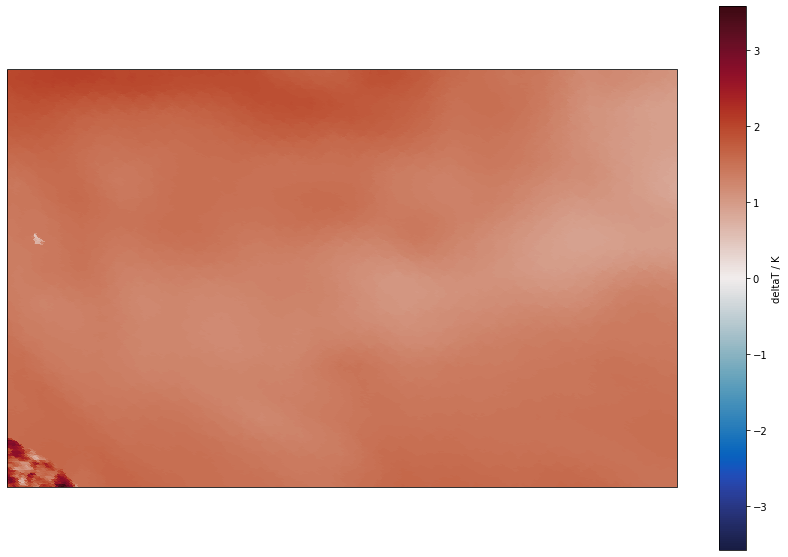

In [10]:
delta = pl4k - ctrl
prelim.plot_delta(delta)

## Time series and spatial variance

One suprise here for me was that the actual sea surface temperature delta in our domain is only around 1K for the RCP4.5 scenario. Lets first quantify this hunch, and then look a the air temperature at 2m, too.

In [11]:
from time import time as time
t1 = time()
may2020 = np.datetime64('2020-05-01T00:00:00.000000000') # first of may 2020
sst_timeseries = delta.where(delta.time < may2020, drop=True).mean(dim='cell')
print(f"Mean delta-T for sea surface eureca domain from the monsoon experiments: {np.mean(sst_timeseries.values)}K")
t2 = time()
print(f"(time estimate for calculating the spatial means of the whole time series: {(t2-t1) * (len(delta.time)/len(sst_timeseries.time)) / 60} min)")

Mean delta-T for sea surface eureca domain from the monsoon experiments: 1.3700754470783276K
(time estimate for calculating the spatial means of the whole time series: 23.402026015520097 min)


In [12]:
t2m_timeseries = prelim.april_timeseries('tas')
print(f"Mean delta-T for air temperature at 2m in the eureca domain from the monsoon experiments: {np.mean(t2m_timeseries.values)}K")

Function 'april_timeseries' executed in 12.7240s
Mean delta-T for air temperature at 2m in the eureca domain from the monsoon experiments: 1.3997649206840117K


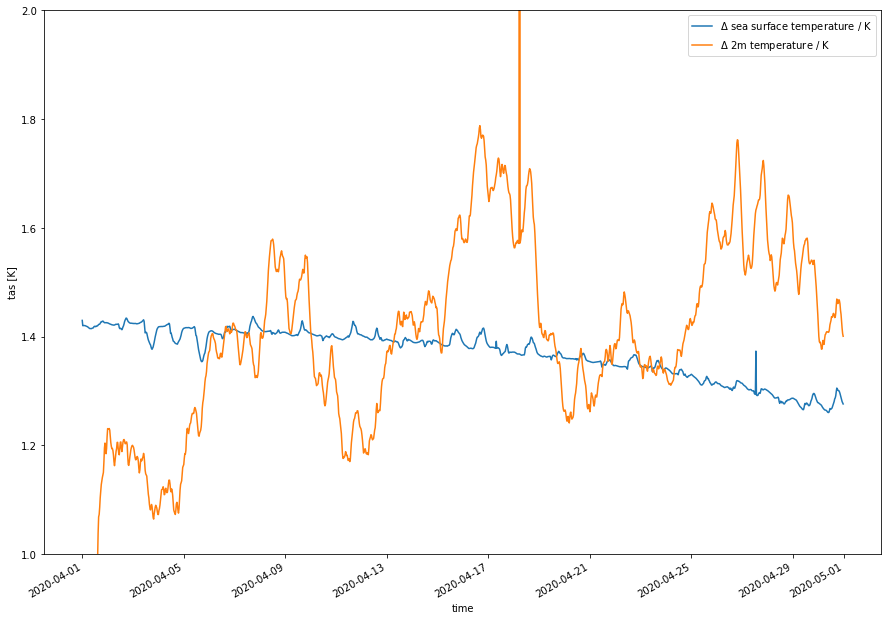

In [13]:
import matplotlib.pyplot as plt

figsize=(15,10)
fig, ax = plt.subplots(figsize=figsize)

label = '$\Delta$ sea surface temperature / K'
sst_timeseries.plot.line(ax=ax, label=label)

label = '$\Delta$ 2m temperature / K'
t2m_timeseries.plot.line(ax=ax, label=label)

# ax.plot(x,y,label=label)
ax.legend()
ax.set_ylim(1.0,2.0)
plt.show()

In [14]:
print(f"Variance in delta-T for sea surface eureca domain from the monsoon experiments: {np.var(sst_timeseries.values)}K")
print(f"Variance in delta-T for air temperature at 2m in the eureca domain from the monsoon experiments: {np.var(t2m_timeseries.values)}K")

Variance in delta-T for sea surface eureca domain from the monsoon experiments: 0.0020080879090985035K
Variance in delta-T for air temperature at 2m in the eureca domain from the monsoon experiments: 0.0489511990232087K


This looks confusing to me. 
 1. Why are SSTs decreasing over the course of April? Shouldn't they rise in the northern hemisphere?
 2. Why are SST and air temperature at 2m trending in different directions?
 
(There are also some strange outliers, but that is not my concern)

Function 'april_timeseries' executed in 13.3834s
Function 'add_line_plot' executed in 229.5579s
Function 'april_timeseries' executed in 13.5490s
Function 'add_line_plot' executed in 234.8643s


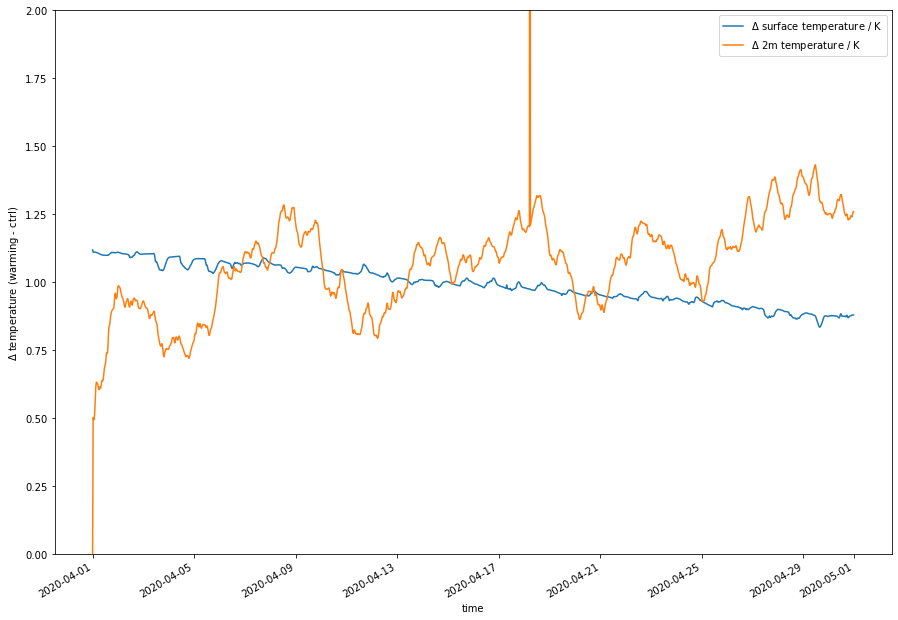

In [17]:
prelim.plot_delta_timeseries_april(
    simulations=['luk1000','luk1011'], 
    variables = ['ts','tas'], 
    ylim = (-0.0, 2.0), 
    ylabel = "$\Delta$ temperature (warming - ctrl)", 
    figsize=(15,10) )

plt.show()

And the deltas seem to be smaller for the more extreme RCP8.5 scenario:

Function 'april_timeseries' executed in 13.0939s
Function 'add_line_plot' executed in 227.5867s
Function 'april_timeseries' executed in 13.6819s
Function 'add_line_plot' executed in 235.0751s


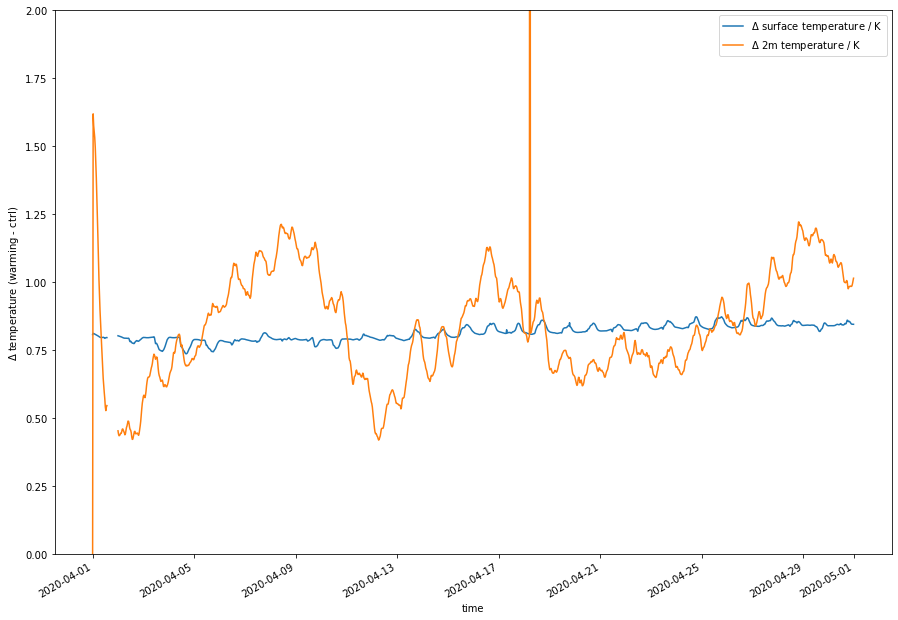

In [16]:
prelim.plot_delta_timeseries_april(
    simulations=['luk1000','luk1020'], 
    variables = ['ts','tas'], 
    ylim = (0.0, 2.0), 
    ylabel = "$\Delta$ temperature (warming - ctrl)", 
    figsize=(15,10) )

plt.show()